In [46]:
import sys
import os
import time
import collections
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

module_path = os.path.abspath(os.path.join('/Users/balbi/Downloads/pyMorfologik-master'))
if module_path not in sys.path:
    sys.path.append(module_path)
from pymorfologik import Morfologik
from pymorfologik.parsing import ListParser
from __future__ import print_function
import string
from multiprocessing import cpu_count, Pool
import dask.dataframe as dd
from dask.multiprocessing import get
import matplotlib.pyplot as plt

%matplotlib inline

In [23]:
def createFileWithLemmatisation():
    commentsWithLemmatisation = pd.DataFrame()
    comments = pd.read_csv('FilmWeb-commentsRates.csv')
    for index, comment in comments.iterrows():
        text = lemmatisation(comment['Text'])
        commentsWithLemmatisation = commentsWithLemmatisation.append({'text': text, 'emotion': comment['emotion'], 'rate': comment['rate']}, ignore_index=True)
    commentsWithLemmatisation.to_csv('FilmWeb-detectingEmotions-lemmatisation.csv', encoding='utf-8', index=False)

In [24]:
def createDataFromFile():
    comments = pd.read_csv('FilmWeb-detectingEmotions-lemmatisation.csv')
    return comments

In [25]:
def lemmatisation(text):
    parser = ListParser()
    stemmer = Morfologik()
    stemming = stemmer.stem([text], parser)
    words_list = list()
    for s in stemming:
        for i in s:
            for l in i:
                if(len(l) > 1):
                    words_list.append(l)
    return words_list

In [32]:
#split (0.8 train_data 0.2 test_data)
def splitData(comments, split):
    comments.loc[comments.emotion == 'neutral', 'emotion'] = "negative"
    #charToRemove= dict.fromkeys('!@#$?.:,')
    #comments['Text'] = comments['Text'].translate(charToRemove)
    comments = comments.reset_index()
    
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    length_train_data = int(split * len(comments))
    train_data = comments[:length_train_data]
    test_data = comments[length_train_data:]
    
    return [train_data, test_data]

def prepereDataForSVM(maximumNegativeRate, mimimumPositiveRate, train_data):
    data = np.empty((0))
    data_labels = np.empty((0))
    
    train_data = train_data[(train_data.rate <= maximumNegativeRate) | (train_data.rate >= mimimumPositiveRate)]
    train_data = train_data.reset_index()
  
    for index, train_data in train_data.iterrows():
        data = np.append(data, train_data['text'])
        data_labels = np.append(data_labels, train_data['emotion'])
    return [data, data_labels]

def prepereDataForSlowosiec(maximumNegativeRate, mimimumPositiveRate, test_data):
    test_data = test_data[(test_data.rate <= maximumNegativeRate) | (test_data.rate >= mimimumPositiveRate)]
    test_data = test_data.reset_index()
    return test_data

In [70]:
def slowosiec(text):
    emotions = pd.read_csv('emotionsTable.csv')
    text = text.replace("[", "")
    text = text.replace(" ", "")
    text = text.replace("]", "")
    words_list = text.split(',')
    numberOfWords = len(words_list)
    result = 0
    if(numberOfWords > 0):
        emotionsCounter = 0
        for el in words_list: 
            if((emotions['word'] == el)).any():
                emotionsCounter += float(emotions.loc[emotions['word'] == el]['sentiment'].mean())  
        result = emotionsCounter/numberOfWords
    return result

In [34]:
def getEmotionStatusOfText(result):
    if(result <= 0):
        return 'negative'
    elif(result > 0):
        return 'positive'

In [35]:
def SVM_liblinear(iterations, dataset, is_shuffle):
    data = dataset[0]
    data_labels = dataset[1]
    
    sss = StratifiedKFold(n_splits=iterations, shuffle=is_shuffle)

    for train_index, test_index in sss.split(data, data_labels):
        train_data = data[train_index]
        train_labels = data_labels[train_index]
        
        vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
        train_vectors = vectorizer.fit_transform(train_data)
        
        classifier_liblinear = svm.LinearSVC()
        classifier_liblinear.fit(train_vectors, train_labels)
        
    return [classifier_liblinear,vectorizer]

In [36]:
def SCV_detectingEmotions(classifier, vectorizer, test_data):
    test_vectors = vectorizer.transform(test_data)
    prediction_liblinear = classifier.predict(test_vectors)
    return prediction_liblinear

In [37]:
def get_length(text):
    return len(text)

def get_length_bin(length):
    return length / 10

def get_score(result):
    return 1 if result else 0

def renderPlot(result_df):
    result_df['correct_guess'] = result_df['detectedEmotion'] == result_df['emotion']
    result_df['score'] = map(get_score, result_df['correct_guess'])
    result_df['text_length'] = map(get_length, result_df['text'])
    result_df['text_length_bin'] = map(get_length_bin, result_df['text_length'])
    grouped = result_df.groupby('text_length_bin', as_index=False)['score'].mean()

    fig, ax = plt.subplots()
    x = grouped.text_length_bin * 10
    y = grouped.score
    fit = np.polyfit(x, y, deg=1)
    ax.plot(x, fit[0] * x + fit[1], color='red')
    ax.scatter(x, y)

    fig.show()

In [74]:
#testing algorithm Slowosiec

import sys
reload(sys)
sys.setdefaultencoding('utf-8')


def calculateOneRow(level_0, index, emotion, rate, text):
    number = slowosiec(text)
    result_emotion = getEmotionStatusOfText(number)
    return {"text": text, "detectedEmotion": result_emotion, 'emotion': emotion, 'rate': rate}

def parallelize(data, func):
    data_split = np.array_split(data, partitions)
    pool = Pool(cores)
    mapResult = pool.map(func, data_split)
    data = pd.concat(mapResult)
    pool.close()
    pool.join()
    return data

cores = cpu_count()
partitions = cores

comments = createDataFromFile()
[train_data, test_data] = splitData(comments,0.8)
test_data.reset_index()
data = prepereDataForSlowosiec(1,10,test_data)

ddata = dd.from_pandas(data, npartitions=partitions)

result = ddata.map_partitions(lambda df: df.apply((lambda row: calculateOneRow(*row)), axis=1)).compute(get=get)
result_df = pd.DataFrame()
for o in result:
    result_df = result_df.append(o, ignore_index=True)

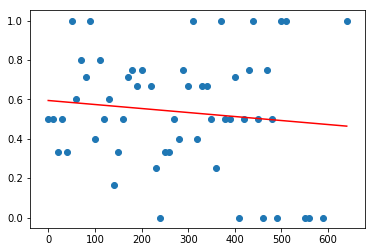

In [75]:
renderPlot(result_df)

In [76]:
len(result_df.loc[result_df['correct_guess'] == True])

122

In [77]:
len(result_df.loc[result_df['correct_guess'] == False])

91

In [78]:
len(result_df)

213